# Projet machine learning
## Objectif
Notre objectif est de créer un classifieur permettant de traduire la langue des signes. Pour ce faire, on va se baser sur le dataset [American sign language](https://www.kaggle.com/datasets/ayuraj/asl-dataset) qui répertorie tous les gestes du standard américain de la langue des signes.

On voudrait également pouvoir faire cette traduction pour d'autres langues, par exemple l'arabe grâce à ce dataset [RGB Arabic Alphabets Sign Language Dataset](https://www.kaggle.com/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset), et voire d'autres langues dans le futur. Par ailleurs, on voudrait également pouvoir détecter dans quelle langue un individu parle en langue des signes.

Pour le déploiement, on voudrait faire un site grâce à streamlit, qui pourrait recevoir des images (voire peut être des vidéos si on y arrive), et qui fait la traduction.

## Préparation de l'environnement

In [ ]:
!unzip ./asl_dataset.zip; # Cas où on charge le dataset directement dansle colab

### Imports

In [11]:
!pip install opencv-python;

     --------------------------------------- 38.6/38.6 MB 28.5 MB/s eta 0:00:00


In [34]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Model
import torchvision.transforms as transforms
from torch.autograd import Variable
import tensorflow as tf
from tensorflow.keras import layers
import torch
import torch.nn
import torchvision.models as models
import string
#from google.colab import drive
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from PIL import ImageFile
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_validate,StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import pickle
import umap
import seaborn as sns
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive (1).zip"; # Cas où on charge le dataset directement dansle colab

## Extraction des données

In [2]:
#ImageFile.LOAD_TRUNCATED_IMAGES = True # Pour éviter une erreur
def load_data(path):
    X_data = []
    y = []
    #path = "./drive/MyDrive/data/asl_dataset/"
    #path = "./dataset/asl_dataset_black_background" # Decommenter si le dataset est dans le colab
    for dirname, _, filenames in tqdm(os.walk(path)):
        for filename in filenames:
            head, tail = os.path.split(dirname)
            y.append(tail.lower())
            X_data.append(cv2.imread(os.path.join(dirname, filename)))
    y = np.array(y, dtype = "<U20")
    return X_data, y
X_data, y = load_data(path = "./dataset/asl_dataset_black_background")

37it [00:05,  6.74it/s]


In [3]:
def plot_accuracies(accuracies, std = None, legend = "Iteration", x_axis = None, rescale_x = True):
    if x_axis is None:
        x_axis = range(1, len(accuracies) + 1)
    if rescale_x:
        plt.xticks(x_axis)
    plt.xlabel(legend)
    plt.ylabel("Accuracy")
    plt.errorbar(x_axis, accuracies, std, linestyle='None', marker='^')


Label :  z


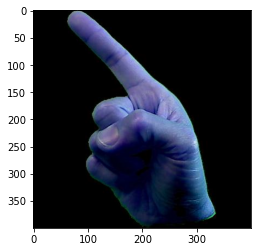

In [7]:
# Affichage des données avec label
index = np.random.randint(0, len(y), 1)[0]
print("Label : ", y[index])
plt.imshow(X_data[index])
plt.show()

In [ ]:
print("Taille d'une image : ", X_data[0].size)

Taille d'une image :  (400, 400)


## Extraction des embeddings

L'objectif est de créer des représentations vectorielles plus petites et plus chargées en sens des images. En effet, les images ont une taille de 400 x 400 x 3 ce qui est bien trop lourd sachant que nous avons 2500 images que nos algorithmes d'apprentissage devront traiter.

Pour ce faire, nous allons utiliser un réseau de neurones pré-entrainés Resnet18, dont on va ôter la dernière couche nommée avg pool qui est destinée à la classification. Voici [le repo github](https://github.com/christiansafka/img2vec) dont nous nous sommes inspirés pour réaliser cette tâche.


![picture](https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)

Source : www.researchgate.net

### Réseau de neurones

In [4]:
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]
RESNET_SHAPE = (224, 224)
def prepare_images(X, cv2 = True):
    """
    X : dataset à traiter
    img : représente l'image qu'on souhaite pré-traiter, type : ndarray
    scalar : Objet de transformation d'image pour redimensionner l'image (par défaut, redimensionne à 224x224)
    normalizer : Objet de transformation d'image pour normaliser les valeurs des pixels (par défaut, normalise selon les valeurs de moyenne et d'écart type spécifiées pour ImageNet)
    to_tensor : Objet de transformation d'image pour convertir l'image en un tenseur (par défaut, convertit l'image en un tenseur)
    """
  # création du réseau de neurones pré-entraîné
    model = models.resnet18(weights = 'ResNet18_Weights.DEFAULT')
  # Récupération de la couche d'embedding (features) du réseau
    layer = model._modules.get("avgpool")
    model.eval()
    scaler = transforms.Resize(RESNET_SHAPE)
    normalizer = transforms.Normalize(mean = RESNET_MEAN, std = RESNET_STD)
    to_tensor = transforms.ToTensor()
    embeddings = []
    for img in tqdm(X):
        if cv2:
            img = transforms.ToPILImage()(img)
        img = Variable(normalizer(to_tensor(scaler(img))).unsqueeze(0))
        embedding = torch.zeros(1, 512, 1, 1)
        def copy_data(m, i, o):
            embedding.copy_(o.data)
        h = layer.register_forward_hook(copy_data)
        model(img)
        h.remove()
        embeddings.append(embedding.flatten())
    return np.array([embedding.numpy() for embedding in embeddings])


In [12]:
X = prepare_images(X_data)

100%|██████████████████████████████████████████████████████████████████████████████| 2515/2515 [02:16<00:00, 18.42it/s]


In [5]:
def save_dataset(X, y, path_to_save):
    """
    X: dataset des embeddings
    y : labels
    path_to_save : chemin vers le fichier où sauvegarder le dataset
    """
    dataset = np.append( y.reshape((len(y), 1)), X , axis = 1)
    df = pd.DataFrame(dataset, columns = ["label"] + [i for i in range(0, len(dataset[0]) - 1)] )
    # Sauvegarde du dataset
    with open(path_to_save, "wb") as f:
        pickle.dump(df, f)

In [54]:
dataset = np.append( y.reshape((len(y), 1)), X , axis = 1)
df = pd.DataFrame(dataset, columns = ["label"] + [i for i in range(0, len(dataset[0]) - 1)] )
# Sauvegarde du dataset
with open("./dataset/embedding_dataset_black_background", "wb") as f:
    pickle.dump(df, f)

In [86]:
# Décommenter si vous venez de lancer le notebook pour charger les embeddings.
with open("./dataset/embedding_dataset_black_background", "rb") as f:
    df = pickle.load(f)
y = df["label"].to_numpy(dtype = "<U20")
X = df.drop("label", axis = 1).to_numpy(dtype = np.float64 )
df

,label,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,0,0.36018032,0.42709622,0.014567755,0.94748175,0.08528258,0.01932602,0.113452025,1.1971961,1.1277869,...,0.3050802,0.24047434,0.30099416,0.96110785,2.0177488,0.43213034,1.1959952,0.120021656,1.011136,3.5230305
1,0,0.25764653,0.7324071,0.007531982,0.95486885,0.17825,0.035486143,0.10847861,1.036097,1.0627438,...,0.36548752,0.5710293,0.3162621,0.7931299,1.7308142,0.45791876,1.6707069,0.06726386,0.94313145,3.8143706
2,0,1.0973548,1.2334919,0.044737328,0.8733688,0.20596719,0.46917507,0.32112545,1.1285882,1.3384262,...,0.38574547,0.7080072,0.17736049,0.538995,1.6459134,0.28054407,1.5169173,0.110367484,1.0878978,3.7527733
3,0,0.7171137,0.11402568,0.0012732355,1.5308076,0.40826723,0.4246754,0.026775321,1.1962273,0.5486058,...,0.23861387,0.1305552,0.2507592,0.85907304,2.638457,0.10720785,1.2238845,0.29445434,0.8534442,3.112849
4,0,0.36896715,0.49052852,0.01518343,1.1164817,0.22344328,0.08264813,0.18708311,0.9045833,1.1163731,...,0.24354027,0.16920307,0.22806612,0.6908026,2.156474,0.6893407,1.3201915,0.21748665,0.7843305,4.1208234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,z,2.5617056,1.0968555,0.059605863,1.3601071,0.26462293,0.008689503,0.25335982,0.9385892,0.9372839,...,0.47877094,0.9572558,0.001286784,1.4498384,2.1445506,0.33309278,2.197302,0.0,0.17142148,3.3041782
2511,z,1.7109569,0.88887984,0.017182408,0.8024241,0.45405018,0.023087444,0.31765223,0.76750505,0.48419243,...,0.27514184,0.6141105,0.027993407,1.3541384,2.3399167,0.5414287,2.1717532,0.016794758,0.2646937,3.3650482
2512,z,2.740924,0.54455006,0.018153952,1.7356882,0.5673779,0.076424405,0.10262534,0.10174843,0.79408145,...,0.4311385,0.676856,0.014838192,1.2945739,1.6073928,0.27455473,1.6103992,0.015018985,0.31972143,4.901655
2513,z,3.435788,1.2060019,0.043858495,1.9407682,1.3611171,0.7599666,0.17792797,0.36479908,1.233776,...,1.0314395,0.94135725,0.05641341,0.71508664,0.8913881,0.30850127,2.473029,0.029056165,0.52736694,4.9549336


In [87]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size = 0.2, train_size = 0.8)

In [88]:
print("Taille Data Apprentissage : ",len(X_train))
print("Taille Data Validation : ",len(X_test))

Taille Data Apprentissage :  2012
Taille Data Validation :  503


### Visualisation

Nous allons utiliser la technique de réduction UMAP (plus efficace que l'ACP) pour observer nos données, et voir si l'on peut détecter des patterns.

In [95]:
reducer = umap.UMAP()
reducer.fit(X)
embedding = reducer.transform(X)

array([[0.34940125, 0.33399735, 0.79880547],
       [0.34940125, 0.33399735, 0.79880547],
       [0.34940125, 0.33399735, 0.79880547]])

<AxesSubplot:xlabel='Feature1', ylabel='Feature2'>

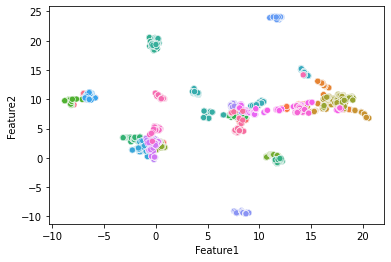

In [132]:

# Création des couleurs de chaque label
labels, counts = np.unique(y, return_counts = True)
colors = []
df = pd.DataFrame(embedding, columns = {"Feature1", "Feature2"})
sns.scatterplot(data=df, x="Feature1", y="Feature2", hue = y, legend = False)
#plt.scatter(embedding[:, 0], embedding[:, 1])

On constate qu'il y'a des clusters bien distincts représentant des caractères différents.

L'apprentissage risque d'être assez simple.

## Apprentissage supervisé

On va tester quelques algorithmes d'apprentissage sur nos données.

### Régression Logistique Multinomiale

In [89]:
# Création d'un objet de régression logistique multinomiale
clf_log = LogisticRegression(max_iter = 1000, tol = 1e-2)

#### Recherche des hyperparamètres avec GridSearch



In [94]:
grille_regression = GridSearchCV(clf_log, param_grid = [{"penalty": ["l2"], "C" : [10 ** i for i in range(-3, 1)], "tol": [1e-2, 1e-1] }, {"penalty": ["none"]}])
grille_regression.fit(X_train, y_train)

C:\Users\Dany\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=LogisticRegression(max_iter=1000, tol=0.01),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l2'],
                          'tol': [0.01, 0.1]},
                         {'penalty': ['none']}])

In [95]:
df1 = pd.DataFrame(grille_regression.cv_results_)
df1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.652989,0.129475,0.001200,0.000402,0.001,l2,0.01,"{'C': 0.001, 'penalty': 'l2', 'tol': 0.01}",0.823821,0.806452,0.825871,0.835821,0.805970,0.819587,0.011653,8
1,0.623201,0.104187,0.001399,0.000488,0.001,l2,0.1,"{'C': 0.001, 'penalty': 'l2', 'tol': 0.1}",0.823821,0.803970,0.825871,0.835821,0.805970,0.819091,0.012239,9
2,1.998200,0.239772,0.001600,0.000490,0.01,l2,0.01,"{'C': 0.01, 'penalty': 'l2', 'tol': 0.01}",0.930521,0.915633,0.920398,0.935323,0.905473,0.921470,0.010630,6
3,1.468599,0.241270,0.001201,0.000400,0.01,l2,0.1,"{'C': 0.01, 'penalty': 'l2', 'tol': 0.1}",0.930521,0.915633,0.920398,0.935323,0.905473,0.921470,0.010630,6
4,5.127612,0.603615,0.001200,0.000399,0.1,l2,0.01,"{'C': 0.1, 'penalty': 'l2', 'tol': 0.01}",0.970223,0.947891,0.952736,0.955224,0.942786,0.953772,0.009264,3
5,2.019623,0.074446,0.001402,0.000489,0.1,l2,0.1,"{'C': 0.1, 'penalty': 'l2', 'tol': 0.1}",0.967742,0.945409,0.955224,0.955224,0.942786,0.953277,0.008818,4
6,5.728940,0.865680,0.001399,0.000489,1,l2,0.01,"{'C': 1, 'penalty': 'l2', 'tol': 0.01}",0.980149,0.950372,0.975124,0.970149,0.955224,0.966204,0.011496,1
7,1.337236,0.141701,0.002599,0.003200,1,l2,0.1,"{'C': 1, 'penalty': 'l2', 'tol': 0.1}",0.982630,0.950372,0.965174,0.970149,0.952736,0.964212,0.011821,2
8,0.395600,0.008662,0.001200,0.000399,NaN,none,NaN,{'penalty': 'none'},0.960298,0.920596,0.950249,0.952736,0.927861,0.942348,0.015334,5


Voici un code normalisant les données.

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
grille_regression = GridSearchCV(clf_log, param_grid = [{"penalty": ["l2"], "C" : [10 ** i for i in range(-3, 1)]}, {"penalty" : ["none"]}])
grille_regression.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000, tol=0.01),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l2']},
                         {'penalty': ['none']}])

In [36]:
df2 = pd.DataFrame(grille_regression.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.430399,0.038970,0.001601,0.000489,0.001,l2,"{'C': 0.001, 'penalty': 'l2'}",0.900744,0.918114,0.907960,0.902985,0.917910,0.909543,0.007299,5
1,0.981201,0.104578,0.001600,0.000490,0.01,l2,"{'C': 0.01, 'penalty': 'l2'}",0.937965,0.935484,0.957711,0.942786,0.962687,0.947327,0.010884,4
2,1.304798,0.071669,0.001402,0.000491,0.1,l2,"{'C': 0.1, 'penalty': 'l2'}",0.962779,0.965261,0.972637,0.962687,0.977612,0.968195,0.005945,2
3,1.237600,0.106423,0.001400,0.000488,1,l2,"{'C': 1, 'penalty': 'l2'}",0.965261,0.967742,0.970149,0.965174,0.975124,0.968690,0.003703,1
4,0.195000,0.012474,0.001201,0.000399,NaN,none,{'penalty': 'none'},0.945409,0.962779,0.962687,0.950249,0.960199,0.956265,0.007116,3


Le modèle ne semble pas avoir été affecté par la normalisation.

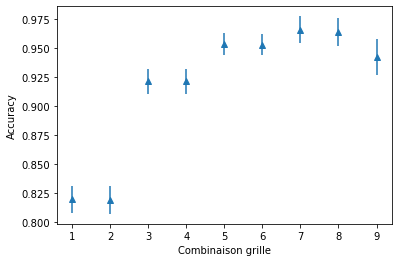

In [232]:
plot_accuracies(df1["mean_test_score"], df1["std_test_score"], "Combinaison grille")

La septième combinaison de paramètres est la meilleure en terme d'accuracy, mais la sixième et la cinquième ont des déviations plus petites. On préfèrera tout de même le modèle avec la plus grande accuracy car sa déviation n'est pas très grande.

#### Evaluation du modèle

In [109]:
clf_log = LogisticRegression(multi_class='multinomial', solver='lbfgs', C = 1, penalty = "l2", max_iter=  2000, tol = 1e-2)
regression_results = cross_validate(clf_log, X_train, y_train, cv=8)


['fit_time', 'score_time', 'test_score']

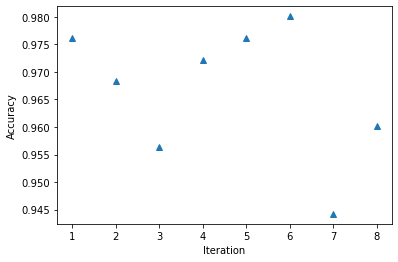

In [233]:
plot_accuracies(regression_results['test_score'])

La déviation est assez grande. Mais une accuracy de 0.96 reste tout à fait raisonnable pour une simple régression logistique.

In [112]:
clf_log.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=2000, multi_class='multinomial', tol=0.01)

#### Test du modèle

In [124]:
print(f"Accuracy regression logistique : {clf_log.score(X_test, y_test): .2f}")

Accuracy regression logistique :  0.98


In [127]:
# Matrice de confusion
y_pred = clf_log.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

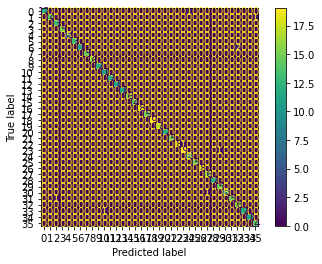

In [137]:
display_conf = ConfusionMatrixDisplay(conf_mat)
display_conf.plot()

In [113]:
# Test
index = np.random.randint(0, len(X_test), 1)[0]
x = X_test[index]
print("Prédiction : ", clf_log.predict([x]))
print("Label : ", y_test[index])

Prédiction :  ['o']
Label :  o


In [156]:
#Test avec de vraies images.
img = cv2.imread("./dataset/asl_alphabet_test/A_test.jpg")
embedding = prepare_images([img])[0]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


In [163]:
print("Predicted label : ", clf_log.predict([embedding])[0])
print("True label : A")

Predicted label :  i
True label : A


In [164]:
img = cv2.imread("./dataset/asl_alphabet_test/testL.jpg")
embedding = prepare_images([img])[0]
print("Predicted label : ", clf_log.predict([embedding])[0])
print("True label : L")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.67it/s]

Predicted label :  7
True label : L


In [191]:
y_deployment

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'L', 'M', 'N',
       'nothing', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
       'Z'], dtype='<U20')

In [202]:
X_deployment, y_deployment = load_data("./dataset/asl_alphabet_test")
where_nothing = np.where(y_deployment == "nothing")[0] #On ne prend pas encore en compte ce label
X_deployment = np.delete(X_deployment, where_nothing)
y_deployment = np.delete(y_deployment, where_nothing)

38it [00:00, 121.79it/s]


In [203]:
X_deployment = prepare_images(X_deployment)

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 17.93it/s]


In [204]:
print("Accuracy sur de vraies données : ", clf_log.score(X_deployment, y_deployment))

Accuracy sur de vraies données :  0.05263157894736842


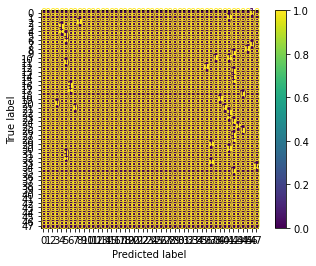

In [205]:
ConfusionMatrixDisplay(confusion_matrix(y_deployment, clf_log.predict(X_deployment))).plot()

L'algorithme est très mauvais pour prédire des vraies données de tests, en dépit d'un excellent score sur le jeu de test provenant du dataset utilisé. Cela montre très clairement que l'algorithme est incapable de généraliser à de vraies images.

Pour s'en assurer, on va essayer d'entraîner une SVM sur le même jeu de données.

### SVM

In [206]:
# Création d'un objet de SVM
clf_SVM = SVC()

#### Recherche des hyperparamètres

In [207]:
grille_SVM = GridSearchCV(clf_SVM, {"C" : [10 ** i for i in range(-4, 2)], "kernel":["linear", "poly", "rbf", "sigmoid"]})
grille_SVM.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [215]:
dfSVM = pd.DataFrame(grille_SVM.cv_results_)
dfSVM

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.677730,0.016881,0.116074,0.001890,0.0001,linear,"{'C': 0.0001, 'kernel': 'linear'}",0.032258,0.032258,0.032338,0.032338,0.032338,0.032306,0.000039,15
1,0.702334,0.037417,0.130791,0.013306,0.0001,poly,"{'C': 0.0001, 'kernel': 'poly'}",0.032258,0.032258,0.032338,0.032338,0.032338,0.032306,0.000039,15
2,0.791332,0.012879,0.281170,0.017546,0.0001,rbf,"{'C': 0.0001, 'kernel': 'rbf'}",0.032258,0.032258,0.032338,0.032338,0.032338,0.032306,0.000039,15
3,0.928258,0.075240,0.210398,0.018856,0.0001,sigmoid,"{'C': 0.0001, 'kernel': 'sigmoid'}",0.032258,0.032258,0.032338,0.032338,0.032338,0.032306,0.000039,15
4,0.448552,0.024691,0.144809,0.038953,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.791563,0.781638,0.798507,0.796020,0.786070,0.790760,0.006222,10
5,0.727391,0.052854,0.117831,0.003642,0.001,poly,"{'C': 0.001, 'kernel': 'poly'}",0.032258,0.032258,0.032338,0.032338,0.032338,0.032306,0.000039,15
6,0.816929,0.021762,0.286821,0.033720,0.001,rbf,"{'C': 0.001, 'kernel': 'rbf'}",0.032258,0.032258,0.032338,0.032338,0.032338,0.032306,0.000039,15
7,0.869502,0.020671,0.149639,0.005293,0.001,sigmoid,"{'C': 0.001, 'kernel': 'sigmoid'}",0.032258,0.032258,0.032338,0.032338,0.032338,0.032306,0.000039,15
8,0.212869,0.001684,0.088705,0.001152,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.955335,0.937965,0.935323,0.962687,0.932836,0.944829,0.011921,7
9,0.677727,0.009785,0.150939,0.050091,0.01,poly,"{'C': 0.01, 'kernel': 'poly'}",0.235732,0.225806,0.243781,0.228856,0.226368,0.232109,0.006821,14


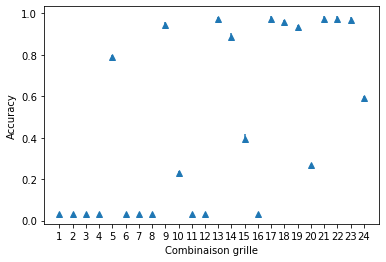

In [235]:
plot_accuracies(dfSVM["mean_test_score"], dfSVM["std_test_score"], "Combinaison grille")


Les déviations sont toutes très petites.
On va choisir le 5 eme meilleure modèle en terme d'accuracy, car il a une bonne déviation pour une perte minime d'accuracy.

#### Test du modèle

In [239]:
clf_SVM = SVC(kernel='rbf', C = 10)
SVM_results = cross_validate(clf_SVM, X, y, cv=10)
sorted(SVM_results.keys())


['fit_time', 'score_time', 'test_score']

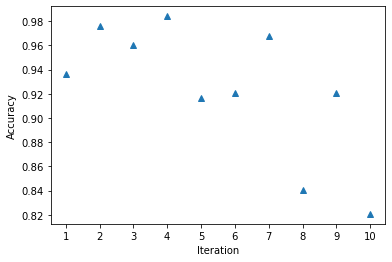

In [240]:
plot_accuracies(SVM_results["test_score"])

La SVM est tout de même assez variable dans ses performances.

In [241]:
clf_SVM.fit(X_train, y_train)

SVC(C=10)

#### Test du modèle

In [243]:
print("Accuracy : ", clf_SVM.score(X_test, y_test))

Accuracy :  0.9821073558648111


In [244]:
print("Accuracy on real test : ", clf_SVM.score(X_deployment, y_deployment))

Accuracy on real test :  0.05263157894736842


Nos modèles sont limités par le dataset utilisé. En effet, notre dataset ne contient que des images de mains découpées sur fond noir, ce qui introduit nécessairement un biais lors de l'apprentissage des embeddings, et donc l'apprentissage des modèles.

Pour pallier à ce problème, nous avons décidé d'enrichir notre dataset de nouvelles données provenant de [ce dataset](https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset), contenant des images en langue des signes sur differents fond, avec parfois même l'apparition de visages humains.

Une autre approche considérée a été d'essayer d'adapter chaque image que l'on allait passer au programme, c'est à dire détecter la main sur l'image, la découper et la placer sur fond noir. Mais il s'agit d'un processus extrêmement coûteux et peu efficace que l'on a vite abandonné.

Le dataset pèse 5GB, on a donc dû se limiter à environ 3-5 % du dataset.

Par ailleurs, le nouveau dataset ne contient pas d'images pour les chiffres en langue des signes, on utilise donc [le dataset des chiffres en langue des signes](https://github.com/ardamavi/Sign-Language-Digits-Dataset), qui va nous permettre d'apporter un peu plus de richesse à nos chiffres actuels (même si ce n'est pas l'idéal). On réduit ce dataset de 75 % pour qu'il ait les mêmes proportions que nos images du dataset initial.

## Enrichissement du dataset

### Nouveau dataset des lettres

In [163]:
X_new_dataset, y_new_dataset = load_data("./dataset/asl_alphabet_train")

27it [01:32,  3.43s/it]


Label :  q


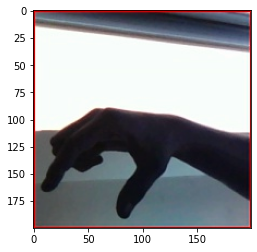

In [165]:
# Affichage des données avec label
index = np.random.randint(0, len(y), 1)[0]
print("Label : ", y[index])
plt.imshow(X_new_dataset[index])
plt.show()

In [166]:
X_new_dataset_embedding = prepare_images(X_new_dataset)

100%|████████████████████████████████████████████████████████████████████████████| 12406/12406 [12:10<00:00, 16.99it/s]


In [169]:
# Sauvegarde
save_dataset(X_new_dataset_embedding, y_new_dataset, "./dataset/embedding_asl_alphabet_train")

### Nouveau dataset des chiffres

In [83]:
X_new_dataset_digits, y_new_dataset_digits = load_data("./dataset/sign_language_digits")

11it [00:04,  2.49it/s]


In [86]:
X_new_dataset_digits_embedding = prepare_images(X_new_dataset_digits)

100%|████████████████████████████████████████████████████████████████████████████████| 734/734 [00:39<00:00, 18.63it/s]


In [90]:
save_dataset(X_new_dataset_digits_embedding, y_new_dataset_digits, "./dataset/embedding_sign_language_digits")

### Fusion des datasets

In [170]:
with open("./dataset/embedding_sign_language_digits", "rb") as f:
    df_digits = pickle.load(f)
with open("./dataset/embedding_asl_alphabet_train", "rb") as f:
    df_new = pickle.load(f)
with open("./dataset/embedding_dataset_black_background", "rb") as f:
    df_old = pickle.load(f)
df = pd.concat([df_digits, df_old, df_new])

In [171]:
y = df["label"].to_numpy()
X = df.drop("label", axis = 1).to_numpy()

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [173]:
print("Taille train : ", len(X_train))
print("Taille test : ", len(X_test))

Taille train :  14089
Taille test :  1566


### Entraînement d'un modèle simple

In [174]:
clf_SVM2 = SVC(C = 0.1, kernel = "linear")
clf_SVM2.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [175]:
clf_SVM2.score(X_test, y_test)

0.9367816091954023

In [176]:
X_deployment, y_deployment = load_data("./dataset/asl_alphabet_test")
X_deployment = prepare_images(X_deployment)

38it [00:00, 87.33it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 16.36it/s]


In [177]:
print("Accuracy de la SVM sur le jeu de déploiement : ", clf_SVM2.score(X_deployment, y_deployment))

Accuracy de la SVM sur le jeu de déploiement :  0.725


In [178]:
print("Prédition : ", clf_SVM2.predict(X_deployment))
print("Labels  réels : ", y_deployment)

Prédition :  ['c' 'a' 'k' 'k' '4' 'f' 'f' 'b' 'd' 'd' 'a' 'a' 'b' 'c' 'p' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'l' 'm' 'n' 'g' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v'
 'w' 'x' 'y' 'z']
Labels  réels :  ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'a' 'a' 'b' 'c' 'c' 'd' 'e' 'f'
 'g' 'h' 'i' 'j' 'k' 'l' 'l' 'm' 'n' 'nothing' 'o' 'p' 'q' 'r' 's' 't' 'u'
 'v' 'w' 'x' 'y' 'z']


L'algorithme est très peu performant sur les chiffres. Nous avons donc décider de ne plus considérer les chiffres, et seulement considérer les lettres de l'alphabet.

Nous allons également réduire la taille du premier dataset de moitié pour éviter qu'il n'influence trop le dataset entier.

## Création du dataset final

In [5]:
with open("./dataset/embedding_asl_alphabet_train", "rb") as f:
    df_new = pickle.load(f)
with open("./dataset/embedding_dataset_black_background", "rb") as f:
    df_old = pickle.load(f)
    


In [6]:
for i in range(0, 10): # Dropping examples with a digit label 
    df_old = pd.concat([df_old, df_old[df_old["label"] == chr(i + ord("0"))]]).drop_duplicates(keep = False)
l = np.arange(0, len(df_old))
np.random.shuffle(l)
percentage_to_keep = 0.5
df_old = df_old.iloc[l[0: math.ceil(percentage_to_keep* len(l))]]

In [9]:
df = pd.concat([df_new, df_old])

In [10]:
with open("./dataset/embedding_dataset_final", "wb") as f:
    pickle.dump(df, f)

In [13]:
y = df["label"].to_numpy()
X = df.drop("label", axis = 1).to_numpy()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [15]:
X_deployment, y_deployment = load_data("./dataset/asl_alphabet_test")
X_deployment = prepare_images(X_deployment)
y_deployment = y_deployment[10:]
X_deployment = X_deployment[10:]

37it [00:00, 95.90it/s]
100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.98it/s]


## Apprentissage

### K-Nearest-neighbors

In [18]:
skfold = StratifiedKFold(n_splits = 5)

In [20]:
MAX_N = 100
scores = []
std_scores = []
time_scores = []
absc = range(1, 19, 2 )
for k in tqdm(absc): # On ingore les valeurs de k qui sont paires
    knn = KNeighborsClassifier(k)
    res = cross_validate(KNeighborsClassifier(k), X_train, y_train, cv = skfold)
    mean_score = res["test_score"].mean()
    std_score = res["test_score"].std()
    time_score = res["score_time"].mean()
    scores.append(mean_score)
    std_scores.append(std_score)
    time_scores.append(time_score)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:20<00:00, 15.65s/it]


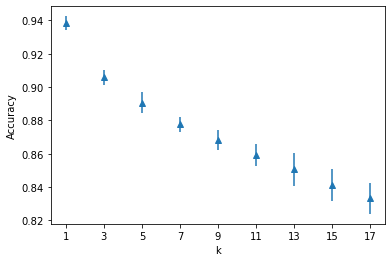

In [31]:
plt.xticks(list(absc))
plot_accuracies(scores, std_scores, legend = "k", x_axis = absc)

k = 1 est la meilleure valeur trouvée.

#### Implementation du modèle

In [16]:
knn = KNeighborsClassifier(1, n_jobs = -1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

In [17]:
print("Accuracy : ", knn.score(X_test, y_test)) 

Accuracy :  0.9602102102102102


L'accuracy trouvée n'est pas la meilleure, mais cela reste correct.

In [18]:
print("Accuracy sur le jeu de deploiement : ", knn.score(X_deployment, y_deployment))

Accuracy sur le jeu de deploiement :  0.9310344827586207


Le knn est une bonne porte d'entrée pour comparer nos modèles.

In [22]:
with open("./models/Knn", "wb") as f:
    pickle.dump(knn, f)

### Simple régression logistique

Pour avoir une idée des meilleurs possibles, et accélérer les tests, on va réduire le dataset.

(Méthode inspirée de [cet article](https://www.linkedin.com/pulse/how-minimize-computational-cost-time-hyperparameters-tuning-aggarwal/))

In [50]:
l = np.arange(0, len(X))
np.random.shuffle(l)
percentage_to_keep = 0.3
reduction = l[0:math.ceil(percentage_to_keep * len(X))]
X_reduced = X[reduction]
y_reduced = y[reduction]
X_train_reduction, X_test_reduction, y_train_reduction, y_test_reduction = train_test_split(X_reduced, y_reduced, test_size = 0.1)

In [56]:
clf_log = LogisticRegression( max_iter = 10000, tol = 1e-2)

In [55]:
skfold = StratifiedKFold(n_splits = 3, shuffle = True)

In [67]:
grille_regression = GridSearchCV(clf_log, param_grid = [{"penalty": ["l2"], "C" : [10 ** i for i in range(-2, 2)] }, {"penalty" : ["none"]}, { "solver" : ["saga"], "penalty": ["elasticnet"], "l1_ratio" : [0.25, 0.5, 0.75],"C" : [10 ** i for i in range(-2, 2)]} ], verbose = 3, cv = skfold )
grille_regression.fit(X_train_reduction, y_train_reduction)

Fitting 3 folds for each of 17 candidates, totalling 51 fits
[CV 1/3] END ................C=0.01, penalty=l2;, score=0.800 total time=   5.2s
[CV 2/3] END ................C=0.01, penalty=l2;, score=0.776 total time=   4.9s
[CV 3/3] END ................C=0.01, penalty=l2;, score=0.791 total time=   3.8s
[CV 1/3] END .................C=0.1, penalty=l2;, score=0.841 total time=   9.1s
[CV 2/3] END .................C=0.1, penalty=l2;, score=0.845 total time=   5.4s
[CV 3/3] END .................C=0.1, penalty=l2;, score=0.841 total time=   5.5s
[CV 1/3] END ...................C=1, penalty=l2;, score=0.842 total time=   7.7s
[CV 2/3] END ...................C=1, penalty=l2;, score=0.846 total time=   7.7s
[CV 3/3] END ...................C=1, penalty=l2;, score=0.845 total time=   8.3s
[CV 1/3] END ..................C=10, penalty=l2;, score=0.840 total time=   7.1s
[CV 2/3] END ..................C=10, penalty=l2;, score=0.847 total time=   6.4s
[CV 3/3] END ..................C=10, penalty=l2;

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=10000, tol=0.01),
             param_grid=[{'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']},
                         {'penalty': ['none']},
                         {'C': [0.01, 0.1, 1, 10],
                          'l1_ratio': [0.25, 0.5, 0.75],
                          'penalty': ['elasticnet'], 'solver': ['saga']}],
             verbose=3)

In [70]:
data_grid_log = pd.DataFrame(grille_regression.cv_results_)
data_grid_log

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_l1_ratio,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,4.462103,0.592702,0.277330,0.014816,0.01,l2,NaN,NaN,"{'C': 0.01, 'penalty': 'l2'}",0.799833,0.776294,0.791319,0.789149,0.009732,12
1,6.477277,1.700533,0.261998,0.012354,0.1,l2,NaN,NaN,"{'C': 0.1, 'penalty': 'l2'}",0.840701,0.844741,0.841402,0.842281,0.001763,3
2,7.701666,0.292279,0.271337,0.002876,1,l2,NaN,NaN,"{'C': 1, 'penalty': 'l2'}",0.842369,0.845576,0.844741,0.844229,0.001359,2
3,6.351705,0.452709,0.254541,0.004065,10,l2,NaN,NaN,"{'C': 10, 'penalty': 'l2'}",0.839867,0.847245,0.847245,0.844786,0.003478,1
4,1.082668,0.129373,0.249664,0.002054,NaN,none,NaN,NaN,{'penalty': 'none'},0.799833,0.808848,0.804674,0.804452,0.003684,10
5,5.261375,0.165866,0.196396,0.004499,0.01,elasticnet,0.25,saga,"{'C': 0.01, 'l1_ratio': 0.25, 'penalty': 'elas...",0.534612,0.522538,0.516694,0.524615,0.007461,15
6,4.716279,0.509042,0.222657,0.004928,0.01,elasticnet,0.5,saga,"{'C': 0.01, 'l1_ratio': 0.5, 'penalty': 'elast...",0.330275,0.326377,0.330551,0.329068,0.001906,16
7,7.372524,0.710620,0.227007,0.003687,0.01,elasticnet,0.75,saga,"{'C': 0.01, 'l1_ratio': 0.75, 'penalty': 'elas...",0.218515,0.200334,0.214524,0.211125,0.007802,17
8,17.321337,1.332506,0.217992,0.001633,0.1,elasticnet,0.25,saga,"{'C': 0.1, 'l1_ratio': 0.25, 'penalty': 'elast...",0.798999,0.801336,0.807179,0.802504,0.003440,11
9,14.903628,0.538487,0.216152,0.004128,0.1,elasticnet,0.5,saga,"{'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasti...",0.774812,0.772955,0.777963,0.775244,0.002067,13


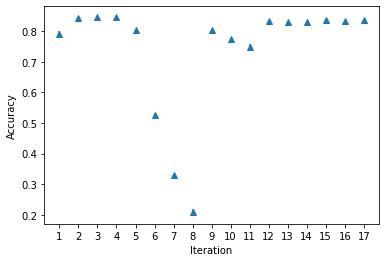

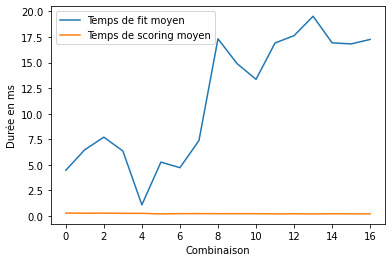

In [77]:
plt.figure(1)
plot_accuracies(data_grid_log["mean_test_score"], data_grid_log["std_test_score"])
plt.figure(2)
absc = range(len(data_grid_log["mean_fit_time"]))
plt.plot(absc, data_grid_log["mean_fit_time"], label = "Temps de fit moyen")
plt.plot(absc, data_grid_log["mean_score_time"], label = "Temps de scoring moyen")
plt.ylabel("Durée en ms")

plt.xlabel("Combinaison")
plt.legend()

Les meilleures performances tournent autour de 0.84.

La durée de fit, et l'accuracy sur le jeu de test en entraînant le modèle sur les données complètes va conditionner notre choix.

In [23]:
clf_log = LogisticRegression( max_iter = 10000, tol = 1e-2, C = 1, penalty = "l2")
clf_log.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=10000, tol=0.01)

In [24]:
print("Accuracy : ", clf_log.score(X_test, y_test))

Accuracy :  0.9316816816816816


In [25]:
print("Accuracy sur les données de deploiement : ", clf_log.score(X_deployment, y_deployment))

Accuracy sur les données de deploiement :  0.8620689655172413


In [81]:
y_pred = clf_log.predict(X_deployment)
y_pred

array(['a', 'n', 'b', 'c', 'p', 'd', 'e', 'f', 'g', 'h', 'r', 'j', 'k',
       'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
       'x', 'y', 'z'], dtype=object)

In [82]:
y_deployment

array(['a', 'a', 'b', 'c', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
       'l', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w',
       'x', 'y', 'z'], dtype='<U20')

In [83]:
y_deployment == y_pred

array([ True, False,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

Le modèle n'a fait que deux erreurs pour les données de déploiement, par contre le temps de fit est extrêmement lent, en contre partie d'un temps de prédiction très court.

In [26]:
clf_log_saga = LogisticRegression( max_iter = 10000, tol = 1e-2, C = 10, l1_ratio = 0.25, penalty = "elasticnet", solver = "saga")
tic = time.time()
clf_log.fit(X_train, y_train)
tac = time.time()

In [90]:
print(f"Durée d'exécution : {tac - tic:.2f} secondes")

Durée d'exécution : 94.50 secondes


In [27]:
tic = time.time()
print(f"Accuracy jeu de test : {clf_log.score(X_test, y_test):.2f}" )
tac = time.time()
print(f"Durée de score sur X_test {tac - tic:.2f} secondes.")
tic = time.time()
print(f"Accuracy jeu de déploiement : {clf_log.score(X_deployment, y_deployment):.2f}")
tac = time.time()
print(f"Durée de score sur X_deployment {tac - tic:.2f} secondes.")

Accuracy jeu de test : 0.93
Durée de score sur X_test 0.22 secondes.
Accuracy jeu de déploiement : 0.86
Durée de score sur X_deployment 0.00 secondes.


La régression logistique est pour le moment le modèle qui performe le moins bien.

In [28]:
with open("./models/reg_log", "wb") as f:
    pickle.dump(clf_log, f)

### SVM

In [101]:
clf_SVM = SVC()
skfold = StratifiedKFold(n_splits = 3, shuffle = True)
param_grid = [{"C" : [10 ** i for i in range(-2, 3)], "kernel":["linear"]},
              {"C" : [10 ** i for i in range(-2, 3)], "kernel":["rbf", "sigmoid"], "gamma": ["scale", "auto"]},
              {"C" : [10 ** i for i in range(-3, 2)], "kernel":["poly"], "degree" : [3, 5, 9]}]
grille_SVM = GridSearchCV(clf_SVM, param_grid = param_grid , verbose = 3, cv = skfold)

grille_SVM.fit(X_reduced,  y_reduced)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END .............C=0.01, kernel=linear;, score=0.836 total time=   2.8s
[CV 2/3] END .............C=0.01, kernel=linear;, score=0.847 total time=   2.5s
[CV 3/3] END .............C=0.01, kernel=linear;, score=0.836 total time=   2.5s
[CV 1/3] END ..............C=0.1, kernel=linear;, score=0.865 total time=   2.5s
[CV 2/3] END ..............C=0.1, kernel=linear;, score=0.871 total time=   2.4s
[CV 3/3] END ..............C=0.1, kernel=linear;, score=0.852 total time=   2.3s
[CV 1/3] END ................C=1, kernel=linear;, score=0.866 total time=   2.3s
[CV 2/3] END ................C=1, kernel=linear;, score=0.872 total time=   2.4s
[CV 3/3] END ................C=1, kernel=linear;, score=0.853 total time=   2.4s
[CV 1/3] END ...............C=10, kernel=linear;, score=0.866 total time=   2.5s
[CV 2/3] END ...............C=10, kernel=linear;, score=0.872 total time=   2.4s
[CV 3/3] END ...............C=10, kernel=linear

[CV 3/3] END ......C=0.1, degree=9, kernel=poly;, score=0.746 total time=   2.5s
[CV 1/3] END ........C=1, degree=3, kernel=poly;, score=0.866 total time=   2.4s
[CV 2/3] END ........C=1, degree=3, kernel=poly;, score=0.876 total time=   2.5s
[CV 3/3] END ........C=1, degree=3, kernel=poly;, score=0.853 total time=   2.5s
[CV 1/3] END ........C=1, degree=5, kernel=poly;, score=0.830 total time=   2.4s
[CV 2/3] END ........C=1, degree=5, kernel=poly;, score=0.845 total time=   2.4s
[CV 3/3] END ........C=1, degree=5, kernel=poly;, score=0.829 total time=   2.5s
[CV 1/3] END ........C=1, degree=9, kernel=poly;, score=0.723 total time=   2.5s
[CV 2/3] END ........C=1, degree=9, kernel=poly;, score=0.738 total time=   2.5s
[CV 3/3] END ........C=1, degree=9, kernel=poly;, score=0.728 total time=   2.5s
[CV 1/3] END .......C=10, degree=3, kernel=poly;, score=0.854 total time=   2.4s
[CV 2/3] END .......C=10, degree=3, kernel=poly;, score=0.877 total time=   2.5s
[CV 3/3] END .......C=10, de

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 10, 100],
                          'gamma': ['scale', 'auto'],
                          'kernel': ['rbf', 'sigmoid']},
                         {'C': [0.001, 0.01, 0.1, 1, 10], 'degree': [3, 5, 9],
                          'kernel': ['poly']}],
             verbose=3)

In [102]:
data_grid_SVM  = pd.DataFrame(grille_SVM.cv_results_)
data_grid_SVM

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,param_gamma,param_degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.392667,0.044465,1.306332,0.093689,0.01,linear,NaN,NaN,"{'C': 0.01, 'kernel': 'linear'}",0.835586,0.846847,0.836213,0.839549,0.005167,11
1,1.280996,0.009931,1.213667,0.081196,0.1,linear,NaN,NaN,"{'C': 0.1, 'kernel': 'linear'}",0.864865,0.870871,0.851991,0.862576,0.007876,9
2,1.282668,0.012472,1.192333,0.020051,1,linear,NaN,NaN,"{'C': 1, 'kernel': 'linear'}",0.865616,0.871622,0.852742,0.863327,0.007876,6
3,1.320614,0.017250,1.287510,0.054896,10,linear,NaN,NaN,"{'C': 10, 'kernel': 'linear'}",0.865616,0.871622,0.852742,0.863327,0.007876,6
4,1.377999,0.049830,1.219001,0.086580,100,linear,NaN,NaN,"{'C': 100, 'kernel': 'linear'}",0.865616,0.871622,0.852742,0.863327,0.007876,6
5,2.857341,0.082638,2.209669,0.087749,0.01,rbf,scale,NaN,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}",0.045045,0.045796,0.045079,0.045307,0.000346,34
6,2.959554,0.027863,1.593670,0.007589,0.01,sigmoid,scale,NaN,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmo...",0.045045,0.045796,0.045079,0.045307,0.000346,34
7,2.783745,0.067585,2.383490,0.079650,0.01,rbf,auto,NaN,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}",0.045045,0.045796,0.045079,0.045307,0.000346,34
8,2.797683,0.029496,1.578244,0.017285,0.01,sigmoid,auto,NaN,"{'C': 0.01, 'gamma': 'auto', 'kernel': 'sigmoid'}",0.045045,0.045796,0.045079,0.045307,0.000346,34
9,3.037221,0.294335,2.561716,0.226352,0.1,rbf,scale,NaN,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}",0.343844,0.322072,0.323065,0.329660,0.010037,29


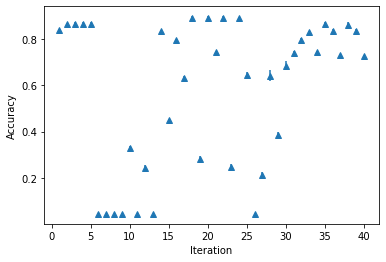

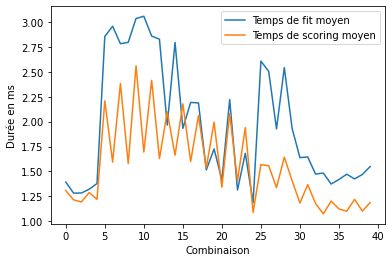

In [115]:
plt.figure(1)
plot_accuracies(data_grid_SVM["mean_test_score"], data_grid_SVM["std_test_score"], rescale_x = False)
plt.figure(2)
absc = range(len(data_grid_SVM["mean_fit_time"]))
plt.plot(absc, data_grid_SVM["mean_fit_time"], label = "Temps de fit moyen")
plt.plot(absc, data_grid_SVM["mean_score_time"], label = "Temps de scoring moyen")
plt.ylabel("Durée en ms")

plt.xlabel("Combinaison")
plt.legend()

La SVM met plus de temps à effectuer des prédictions que la régression logistique, mais prend moins de temps pour fit les données.

Cela va s'avérer utile pour tester nos hyperparamètres sur les données complètes.

In [29]:
clf_SVM = SVC(C =  100, gamma =  'scale', kernel =  'rbf')
tic = time.time()
clf_SVM.fit(X_train, y_train)
tac = time.time()
print(f"Durée de fit {tac - tic:.2f} secondes.")

Durée de fit 17.77 secondes.


La durée de fit est environ 5 fois plus rapide que celle de la régression logistique.

In [30]:
tic = time.time()
print(f"Accuracy jeu de test : {clf_SVM.score(X_test, y_test):.2f}" )
tac = time.time()
print(f"Durée de score sur X_test {tac - tic:.2f} secondes.")
tic = time.time()
print(f"Accuracy jeu de déploiement : {clf_SVM.score(X_deployment, y_deployment):.2f}")
tac = time.time()
print(f"Durée de score sur X_deployment {tac - tic:.2f} secondes.")

Accuracy jeu de test : 0.97
Durée de score sur X_test 6.03 secondes.
Accuracy jeu de déploiement : 0.93
Durée de score sur X_deployment 0.12 secondes.


L'accuracy est meilleure que celle de la regression logistique, malgré un temps de prédiction 30 fois plus lent.

In [51]:
with open("./models/SVM", "wb") as f:
    pickle.dump(clf_SVM, f)

In [134]:
# Test d'une autre SVM
clf_SVM2 = SVC(C =  10, degree =  4, kernel =  'poly')
clf_SVM2.fit(X_train, y_train)

SVC(C=10, degree=4, kernel='poly')

In [135]:
print(f"Accuracy jeu de test : {clf_SVM2.score(X_test, y_test):.2f}" )
print(f"Accuracy jeu de déploiement : {clf_SVM2.score(X_deployment, y_deployment):.2f}")


Accuracy jeu de test : 0.95
Accuracy jeu de déploiement : 0.93


In [142]:
# Test d'une autre SVM
clf_SVM3 = SVC(C = 1, kernel =  'linear')
clf_SVM3.fit(X_train, y_train)
print(f"Accuracy jeu de test : {clf_SVM3.score(X_test, y_test):.2f}" )
print(f"Accuracy jeu de déploiement : {clf_SVM3.score(X_deployment, y_deployment):.2f}")

Accuracy jeu de test : 0.93
Accuracy jeu de déploiement : 0.93


Les performances sont sensiblement les mêmes pour les trois modèles, excepté le modèle linéaire qui performe moins sur le jeu de test.

### Arbres de décisions

#### Decision Tree

La méthode recherche d'hyperparamètres des arbres de décisions a été inspirée par [cet article](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680).

In [149]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_train, y_train)
print(f"Accuracy train :  {clf_tree.score(X_train, y_train):.2f}")
print(f"Accuracy test :  {clf_tree.score(X_test, y_test):.2f}")

Accuracy train :  1.00
Accuracy test :  0.52


In [161]:
clf_tree = DecisionTreeClassifier(max_depth = 30, min_samples_split = 30, min_samples_leaf = 5)
clf_tree.fit(X_train, y_train)
print(f"Accuracy train :  {clf_tree.score(X_train, y_train):.2f}")
print(f"Accuracy test :  {clf_tree.score(X_test, y_test):.2f}")

Accuracy train :  0.70
Accuracy test :  0.47


L'arbre a clairement surappris les données de train et généralise très mal.

En modifiant les hyperparamètres, nous n'arrivons pas à dépasser l'accuracy de 0.52 sur le jeu de tests. L'arbre de décision ne semble pas être fait pour nos données.

#### Random Forest

In [219]:
clf_rf = RandomForestClassifier(n_estimators = 200)
clf_rf.fit(X_train_reduction, y_train_reduction)
print(f"Accuracy train :  {clf_rf.score(X_train_reduction, y_train_reduction):.2f}")
print(f"Accuracy test :  {clf_rf.score(X_test_reduction, y_test_reduction):.2f}")

Accuracy train :  1.00
Accuracy test :  0.81


In [53]:
clf_rf = RandomForestClassifier(n_estimators = 200)
tic = time.time()
clf_rf.fit(X_train, y_train)
tac = time.time()
print(f"Durée de fit : {tac - tic:.2f} secondes" )
print(f"Accuracy train :  {clf_rf.score(X_train, y_train):.2f}")
print(f"Accuracy test :  {clf_rf.score(X_test, y_test):.2f}")

Durée de fit : 58.43 secondes
Accuracy train :  1.00
Accuracy test :  0.93


Random Forest fournit une bonne accuracy de test.

In [33]:
with open("./models/RandomForest", "wb") as f:
    pickle.dump(clf_rf, f)

### Réseaux de neurones

In [38]:
clf_mlp = MLPClassifier(hidden_layer_sizes = (290,)) # Un nombre de layer de l'ordre de la moyenne sizeinput sizeoutput
tic = time.time()
clf_mlp.fit(X_train, y_train)
tac = time.time()
print(f"Durée de fit : {tac - tic:.2f} secondes" )
print(f"Accuracy train :  {clf_mlp.score(X_train, y_train):.2f}")
print(f"Accuracy test :  {clf_mlp.score(X_test, y_test):.2f}")

Durée de fit : 71.55 secondes
Accuracy train :  1.00
Accuracy test :  0.94


In [39]:
with open("./models/MLP", "wb") as f:
    pickle.dump(clf_mlp, f)

## Limites de notre démarche

In [44]:
x = []
for i in ["D", "A", "N", "Y"]:
    x.append(cv2.imread("./dataset/asl_alphabet_test/testDany/test" + str(i) + ".jpeg"))
    #print("C:\\Users\\Dany\\Downloads\\test" + str(i) + ".jpeg")
    #x.append(cv2.imread("C:\\Users\\Dany\\Downloads\test" + str(i) + ".jpeg"))

x = prepare_images(x)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.08it/s]


In [45]:
clf_mlp.predict(x)

array(['o', 'g', 'a', 'c'], dtype='<U1')

In [47]:
clf_log.predict(x)

array(['r', 'g', 'g', 'c'], dtype=object)

In [48]:
knn.predict(x)

array(['o', 'l', 'a', 'a'], dtype=object)

In [49]:
clf_SVM.predict(x)

array(['c', 'g', 'g', 'c'], dtype=object)

In [50]:
clf_rf.predict(x)

array(['c', 'y', 'i', 'q'], dtype=object)

Aucun des modèles n'a réussi à predire les 4 lettres "Dany", ce qui illustre parfaitement les limites de notre modèle.